In [1]:
import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from utils.addtime import AddTime, LeadLag

import utils_roughvol
import functionalities
import deep_sets

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

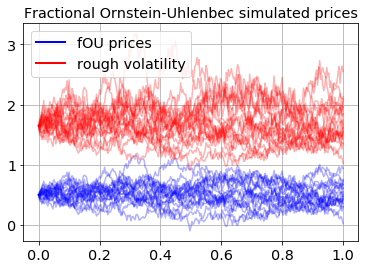

In [2]:
tot = 20
l = 300
df = pd.DataFrame(data=[utils_roughvol.fOU_generator(k*1e-4,length=l) for k in range(1,tot)], columns=np.linspace(0,1,l+1),
                  index=['alpha = {:.1f} x 10^-4'.format(k) for k in range(1,tot)]).T
df_vol = df.apply(lambda x: np.exp(x))


custom_lines = [Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2)]
fig, ax = plt.subplots()
df.plot(grid=True, title='Fractional Ornstein-Uhlenbec simulated prices',legend=False,c='blue',alpha=0.3, ax=ax)
df_vol.plot(grid=True, legend=False,c='red',alpha=0.3,ax=ax)
ax.legend(custom_lines, ['fOU prices', 'rough volatility'])
plt.savefig('pictures/fOU_rough_vol.png')
plt.show()

# Set up learning parameters

In [3]:
n_bags = 100
n_items = 25

y = np.linspace(1e-6, 1e0, n_bags)

In [5]:
X = []
    
for a in tqdm(y):
    intermediate = []
    for n in range(n_items):
        path = np.exp(utils_roughvol.fOU_generator(a, length=l)).reshape(-1,1)
        intermediate.append(path)
    X.append(intermediate)

In [ ]:
importlib.reload(functionalities)

# Poly-SVM

In [15]:
for deg in [1,2,3]:
    print(functionalities.poly_SVM(deg, X, y))

100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    3.9s finished
  0%|          | 0/100 [00:00<?, ?it/s]

(0.14337751756845726, 0.0994079462479601)


100%|██████████| 100/100 [05:51<00:00,  2.91s/it]


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.5min finished
  0%|          | 0/100 [00:00<?, ?it/s]

(0.14257384931951553, 0.09950317646763926)


  2%|▏         | 2/100 [11:51<9:40:57, 355.68s/it]

KeyboardInterrupt: 

# RBF-RBF

In [10]:
print(functionalities.RBF_RBF_SVM(X,y))

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3938 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  4.8min finished


(0.054092529162663994, 0.04420917676479464)


# ESig-SVM

In [9]:
for dep in [3,4]:
    print(functionalities.ESig_SVM(dep, X, y))

100%|██████████| 100/100 [00:01<00:00, 56.84it/s]


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   22.6s finished
  4%|▍         | 4/100 [00:00<00:02, 39.29it/s]

(0.0020530879417530895, 0.0018228584197070368)


100%|██████████| 100/100 [00:02<00:00, 42.69it/s]


Fitting 3 folds for each of 180 candidates, totalling 540 fits
(0.003033419577722751, 0.0028852187461406056)


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   29.8s finished


# Pathwise-ESig-SVM

In [8]:
functionalities.SigESig_LinReg(2, 2, X, y)

100%|██████████| 100/100 [00:01<00:00, 80.04it/s]


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.1s finished


(0.001628622766627338, 0.001351815752608042)

# Neural Net approach (Deep Sets) 

https://arxiv.org/pdf/1703.06114.pdf

In [46]:
importlib.reload(deep_sets)

<module 'deep_sets' from '/home/salvi/notebooks/deep_sets.py'>

In [47]:
batch_size = 20
nb_epoch = 1000

In [48]:
MSEs = []

for j in range(3):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.343406
Train loss: 0.000182
Train loss: 0.000205
Train loss: 0.000220
Train loss: 0.000355
Train loss: 0.259475
Train loss: 0.050860
Train loss: 0.023873
Train loss: 0.017892
Train loss: 0.008366
Train loss: 0.082217
Train loss: 0.023097
Train loss: 0.009599
Train loss: 0.000844
Train loss: 0.052465
0.10684829722952903 0.04729081823475066


# Deep Set adapted to sequential data: DeepSet-RNN

In [49]:
MSEs = []

for j in range(3):
    
    X = []
    for a in y:
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a)))
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetRNN

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 1.282355
Train loss: 0.027482
Train loss: 0.011692
Train loss: 0.009917
Train loss: 0.066314
Train loss: 0.180547
Train loss: 0.060701
Train loss: 0.018004
Train loss: 0.018597
Train loss: 0.036759
Train loss: 2.595124
Train loss: 0.004343
Train loss: 0.001999
Train loss: 0.001015
Train loss: 0.002297
0.09799090910904244 0.015345356132909119


# Deep Set adapted to sequential data: DeepSet-GRU

In [50]:
MSEs = []

for j in range(3):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetGRU

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 6.582266
Train loss: 0.015819
Train loss: 0.007256
Train loss: 0.000512
Train loss: 0.000172
Train loss: 6.065936
Train loss: 0.004265
Train loss: 0.000724
Train loss: 0.000429
Train loss: 0.000055
Train loss: 1.644443
Train loss: 0.006352
Train loss: 0.000415
Train loss: 0.000062
Train loss: 0.000031
0.09537933442453171 0.02407313820520648


# Deep Set adapted to sequential data: DeepSet-LSTM

In [51]:
MSEs = []

for j in range(3):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetLSTM

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 3.400441
Train loss: 0.007780
Train loss: 0.007279
Train loss: 0.006961
Train loss: 0.006840
Train loss: 3.023806
Train loss: 0.024671
Train loss: 0.018774
Train loss: 0.010361
Train loss: 0.004697
Train loss: 1.509271
Train loss: 0.016074
Train loss: 0.002039
Train loss: 0.000114
Train loss: 0.000035
0.10005326725610453 0.022452656572338713
